<a href="https://colab.research.google.com/github/AlmeidaAlin3/AI-Synthesized_Voices_Clusterization/blob/main/aline.almeida/DQN/aa_DQN_freeway.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Freeway

This is the **second project** for the MC935rA/MO436A - Reinforcement Learning course, taught by Prof. Esther Colombini.

In this project we propose to apply Deep Reinforcement Learning methods to teach an agent how to play the Freeway Atari game.

**Group members:**
- Aline Gabriel de Almeida
- Dionisius Oliveira Mayr (229060)
- Leonardo de Oliveira Ramos (171941)
- Marianna de Pinho Severo (264960)
- Victor Jesús Sotelo Chico (265173)

## Freeway game

<center><img src=https://raw.githubusercontent.com/DionisiusMayr/FreewayGame/main/freeway/img/Freeway_logo.png>
</center>

Freeway is a video game written by David Crane for the Atari 2600 and published by Activision [[1]](https://en.wikipedia.org/wiki/Freeway_(video_game)).

In the game, two players compete against each other trying to make their chickens cross the street, while evading the cars passing by.
There are three possible actions: staying still, moving forward or moving backward.
Each time a chicken collides with a car, it is forced back some spaces and takes a while until the chicken regains its control.

When a chicken is successfully guided across the freeway, it is awarded one point and moved to the initial space, where it will try to cross the street again.
The game offers multiple scenarios with different vehicles configurations (varying the type, frequency and speed of them) and plays for 2 minutes and 16 seconds.
During the 8 last seconds the scores will start blinking to indicate that the game is close to end.
Whoever has the most points after this, wins the game!

The image was extracted from the [manual of the game](https://www.gamesdatabase.org/Media/SYSTEM/Atari_2600/Manual/formated/Freeway_-_1981_-_Zellers.pdf).

[1 - Wikipedia - Freeway](https://en.wikipedia.org/wiki/Freeway_(video_game))

# Environment

We will be using the [Stable Baselines](https://stable-baselines.readthedocs.io/en/master/index.html) toolkit.
This toolkit is a set of improved implementations of Reinforcement LEarning algorithms based on [OpenAI Baselines](https://github.com/openai/baselines).

Although the game offers multiple scenarios, we are going to consider only the first one. Also, we will be controlling a *single chicken*, while we try to maximize its score.

In this configuration, there are ten lanes and each lane contains exactly one car (with a different speed and direction).
Whenever an action is chosen, it is repeated for $k$ frames, $k \in \{2, 3, 4\}$.

This means that our environment is **stochastic** and it is also **episodic**, with its terminal state being reached whenever 2 minutes and 16 seconds have passed.

You can find more information regarding the environment used at [Freeway-ram-v0](https://gym.openai.com/envs/Freeway-v0/).

# Setup

Install the dependencies:
```sh
pip install -r requirements.txt
pip install stable-baselines
pip install tensorflow==1.15.0
```

# Useful Resources

Here you can find a list of useful links and materials that were used during this project.

* [Freeway-ram-v0 from OpenAI Gym](https://gym.openai.com/envs/Freeway-ram-v0/)
* [Manual of the game](https://www.gamesdatabase.org/Media/SYSTEM/Atari_2600/Manual/formated/Freeway_-_1981_-_Zellers.pdf)
* [Freeway Disassembly](http://www.bjars.com/disassemblies.html)
* [Atari Ram Annotations](https://github.com/mila-iqia/atari-representation-learning/blob/master/atariari/benchmark/ram_annotations.py)
* [Freeway Benchmarks](https://paperswithcode.com/sota/atari-games-on-atari-2600-freeway)

# Imports

In [ ]:
import sys
sys.path.append('../')  # Enable importing from `src` folder

In [ ]:
%matplotlib inline
import statistics
from collections import defaultdict
from functools import lru_cache
from typing import List

import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import src.agents as agents
import src.episode as episode
import src.environment as environment
import src.aux_plots as aux_plots
import src.serializer as serializer
import src.gif as gif

import tensorflow as tf

import gym
from stable_baselines.common import make_vec_env
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack
from stable_baselines.common.atari_wrappers import make_atari

from stable_baselines.deepq.policies import CnnPolicy
from stable_baselines import DQN

In [ ]:
def print_result(i, scores, total_reward, score):
    if i % 10 == 0:
        print(f"Run [{i:4}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")

In [ ]:
def read_int_array_from_file(fn: str):
    with open(f"./experiments/{fn}") as f:
        return [int(x) for x in f.read().splitlines()]

# Action space

As we said above, the agent in this game has three possible actions at each frame, each represented by an integer:

* 0: Stay
* 1: Move forward
* 2: Move backward

# Baseline

## State of the art benchmarks

The image bellow (extracted from https://paperswithcode.com/sota/atari-games-on-atari-2600-freeway) shows the evolution of the scores over time using different techniques.

Today, the state of the art approaches are making 34.0 points, using Deep Reinforcement Learning methods.

<center><img src=https://raw.githubusercontent.com/DionisiusMayr/FreewayGame/47d8d1fd3b921471738b30b5f9ae447593705b09/freeway/img/state_of_art_scores.png>
</center>



## Simple baseline agent

As a simple baseline, we are using an agent that always moves **up**, regardless of the rewards received or the current state.

In [ ]:
env, initial_state = environment.get_env()

In [ ]:
agent = agents.Baseline()

In [ ]:
total_rewards = []
n_runs = 10

In [ ]:
%%time
for i in range(n_runs):
    render = i % 10 == 0

    game_over = False
    state = env.reset()
    action = agent.act(state)

    total_reward = 0

    while not game_over:
        if render:
            time.sleep(0.01)
            env.render()

        ob, reward, game_over, _ = env.step(action)

        total_reward += reward
        action = agent.act(state)  # Next action

    total_rewards.append(total_reward)

CPU times: user 21.5 s, sys: 544 ms, total: 22.1 s
Wall time: 50 s


In [ ]:
total_rewards

[23.0, 21.0, 23.0, 21.0, 21.0, 21.0, 23.0, 21.0, 23.0, 21.0]

In [ ]:
baseline_mean_score = np.mean(total_rewards)
baseline_mean_score

21.8

As we can see, this agent usually scores 21 or 23 points (as shown in the images bellow). It depends on the the values of $k$ sampled, and on average it scores about 21.8 points per run.

<center><img src=https://raw.githubusercontent.com/DionisiusMayr/FreewayGame/47d8d1fd3b921471738b30b5f9ae447593705b09/freeway/img/baseline_1.png>
</center>

<center><img src=https://raw.githubusercontent.com/DionisiusMayr/FreewayGame/47d8d1fd3b921471738b30b5f9ae447593705b09/freeway/img/baseline_2.png>
</center>


# State Representation

Since the tabular methods we are going to use work with some representation of the actual environment state, we will need to understand it better in order to effectively approach this problem.

## Atari 2600

Before talking about the state representation, it is important to understand how the Atari 2600 works.

Atari 2600 is a video game released in 1977 by the American Atari, Inc.
Its **8-bit** microprocessor was of the MOS **6502** family and it had **128 bytes** of RAM.

And these 128 bytes are what really matters here.

---

Recall that Gym gives us the RAM memory of the Atari as the state representation.
In other words, it gives us an 128-element `np.array`, where each element of the array is an `uint8` (*integer values ranging from 0 to 255*).

That said, we have (in theory) $256^{128} \approx 1.8 \cdot 10^{308}$ possible game states!

This is *far* from being manageable, and thus we need to come up with a different approch to represent our state if we want our algorithms to converge.

One might argue that the RAM state is *sparse* and although that is true, it is still not sparse enough to apply tabular methods.

# Reward Policy

In the base environment we are awarded on point each time we successfully cross the freeway.

# Hyper Parameters

In [ ]:
GAMMA = 0.99
LEARNING_RATE = 0.0005
EXPLORATION_RATE = 0.1

# Methodology

Since it takes a lot of time to train the models, we won't train them all in this report.
Instead, we will be load the results of our simulations and specifying the parameters used to obtain those results.
Of course, it is possible to reproduce our results simply by running the algorithms here using the same hyper parameters as specified.

Whenever possible, we will be adding plots comparing different approaches and parameters, as well as adding gifs in this notebook so that we can visualize the development of the agent and unique strategies that they learned.

Also, we focused a lot of our experiments on Q-Learning, since it was showing the most promissor results.
Monte Carlo methods didn't really work out, and SARSA($\lambda$) methods took way too much time to run (roughly 12 hours per 2k iterations!).
Since QLearning and SARSA aren't really that different, we applied most of the knowledge we acquired from the QLearning experiments on SARSA, varying only its unique parameter, $\lambda$, in steps of 0.2.

Also, it is worth mentioning that we left the code used by each agent inside `./src/agents.py` and provided a model of implementing the environment along the notebook, with the `n_runs` parameter (that controls the number of episodes used in to train the algorithm) set to `1`.

---

# DQN

# Q-Learning

The Q-learning algorithm receives the $\gamma$ and the $N0$ parameters.  

$\gamma$ is the discount factor; This parameters determines the importance of future rewards. A value of 0 makes the agent short-sighned by only considering current rewards, while a factor approaching 1 will make it strive for a long term reward.  

The $N0$ parameter is used to define the agent's exploration rate $\epsilon$, where $\epsilon = N0/(N0+N_{sa})$ and $N_{sa}$ is the number of visits in the state $s$ where the action $a$ was taken.

In the algorithm, the action-value function is initialized to zero. Then, at each time $t$ the agent selects an action $a_t$, observes a reward $r_t$, enters a new state $s_{s+1}$, and $Q$ is updated:

$Q_{new}(s_t, a_t) :=  Q(s_t, a_t)+\alpha (r_t + \gamma.max_aQ(s_{t+1},a)-Q(s_t, a_t))$

The learning rate $\alpha$ is defined as $\alpha = 1/N_{sa}$, where $N_{sa}$ is the number of times that the specific state-action pair has already occured.

In [ ]:
env, initial_state = environment.get_env()

In [ ]:
agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

In [ ]:
scores = []
total_rewards = []

In [ ]:
%%time
n_runs = 1

for i in range(n_runs):
    render = i % 200 == 201

    game_over = False
    state = env.reset()
    state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
    action = agent.act(state)
    
    score = 0
    total_reward = 0

    while not game_over:
        if render:
            time.sleep(0.025)
            env.render()

        old_state = state
        ob, reward, game_over, _ = env.step(action)

        ob = reduce_state(ob)
        reward = reward_policy(reward, ob, action)

        total_reward += reward

        if reward == reward_policy.REWARD_IF_CROSS:
            score += 1

        state = ob[RAM_mask].data.tobytes()

        agent.update_Q(old_state, state, action, reward)

        action = agent.act(state)  # Next action

    scores.append(score)
    total_rewards.append(total_reward)

    print_result(i, scores, total_reward, score)

Run [   0] - Total reward:   12.00 Mean scores: 12.00 Means Scores[:-10]: 12.00 Score: 12 
CPU times: user 2.02 s, sys: 0 ns, total: 2.02 s
Wall time: 2.02 s


## Serialize the model

In [ ]:
# Optional! You can use this code to serialize models!
# exp = serializer.Experiment(agent, scores, total_rewards, reduce_state, reward_policy)
# exp.save_experiment('QL_EXPERIMENT')

## Experiments

### Influence of the number of actions

Here we will compare the impact that the number of possible actions (3 vs 2) has on our score.

To do so, we will run the QLearn algorithm twice, with 3 actions and with 2 actions, and then compare the scores obtained. The complete set of parameters used is shown bellow:

Parameters used:

| Parameter | A2 | A3 |
|------|----|----|
| `GAMMA` | 0.99 | 0.99 |
| `AVAILABLE_ACTIONS` | 2 | 3 |
| `N0` | 2.5 | 2.5 |
| `CROSS` | 1 | 1 |
| `COLLISION` | 0 | 0 |
| `STILL` | 0 | 0 |

In [ ]:
scores_2act = read_int_array_from_file("./QL/QL_scores_2act.txt")
total_rewards_2act = read_int_array_from_file("./QL/QL_total_rewards_2act.txt")
scores_3act = read_int_array_from_file("./QL/QL_scores_3act.txt")
total_rewards_3act = read_int_array_from_file("./QL/QL_total_rewards_3act.txt")

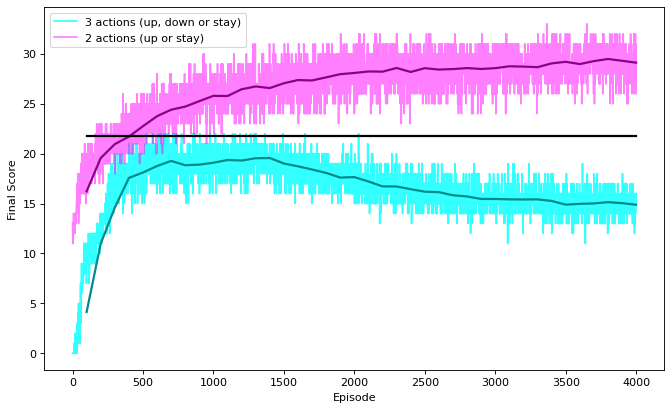

In [ ]:
baseline = [baseline_mean_score for i in range(4000)]

ax = aux_plots.plot_2scores(scores_3act[:4000], scores_2act[:4000], "3 actions (up, down or stay)", "2 actions (up or stay)")
aux_plots.moving_average(scores_2act[:4000], ax, label='2 actions moving avg', color='darkmagenta')
aux_plots.moving_average(scores_3act[:4000], ax, label='3 actions moving avg', color='darkcyan')
aux_plots.moving_average(baseline[:4000], ax, label='Baseline', color='black')

From the graph above, we can see that when using only two actions the agent learns faster than with three actions, thus leading to better results in less iterations.

As we said before, this is expected and we will now be focusing only on testing with two actions.

Since we are using the default reward policy, the reward graph is exactly the same as the score, and thus we won't be showing it here.

It might seem strange at first that using three actions is presenting a decrease in the performance, and bellow we  show various gifs comparing their behavior.

| #Episodes | 0 | 500 | 1000 | 1500 | 2000 |
|------|----|---|---|---|---|
| Three actions | ![QL-R3_0](./gif/QL_base_3_actions_i0.gif) | ![QL-R3_500](./gif/QL_base_3_actions_i500.gif) | ![QL-R3_1000](./gif/QL_base_3_actions_i1000.gif) | ![QL-R3_1500](./gif/QL_base_3_actions_i1500.gif) | ![QL-R3_2000](./gif/QL_base_3_actions_i2000.gif) |

We can see that at the beginning (0 episodes) and also after 1000 episodes, the chicken tries a lot to go back and forth, losing a lot of time in doing so.
We think that this happens because it is much more likely for us to reach different states, even though they aren't particularly good.
And when we arrive at a new state, we have to explore it some times, until we start to really exploit, leading to poor results.
Also, sometimes the 500 and 1000-chicken seems to avoid some cars, but since it doesn't happen so often (it collides a lot as well), we can't really say that it is learning to avoid collisions.

Bellow you can find two gifs comparing the different behaviors of these two agents after 4k episodes.

| #Episodes | Two actions | Three actions |
|------|----|---|
| 4000 | ![QL-A2](./gif/QL_scores_2act.gif) | ![QL-A3](./gif/QL_base_3_actions.gif) | 

Notice that the three actions chicken spends some time going back and forth, instead of trying to cross the lane, and most of the time it does this for no aparent reason.
While the two actions chicken is able to score 21 points, the three actions chicken scores only 16.

### Influence of the reward values

In order to investigate the influence of the reward values in the agent behavior, we ran the algorithm using three different sets of reward values.

* **R1:** Positive rewards for crossing: it offered a sparse reward to the agent: +1 if the chicken cross all the lanes.  
* **R2:** Positive rewards for crossing and negative reward for colliding: it given +1 for crossing all the lanes and -1 if the chicken collide. Thus, we expect the agent to be encouraged to cross the lanes (positive reward) and to avoid collisions (negative reward).  
* **R3:** Huge positive reward for crossing and negative reward for colliding or staying in the same position: it increased the reward for crossing all the lanes to +500 and give -10 when the chicken collide. It also gives a negative reward of -1 when the agent decide to **still**. Thus we expect the chicken to cross all the lanes faster and increase the final score.

| Parameter | R1 | R2 | R3 |
|------|----|----|----|
| `GAMMA` | 0.99 | 0.99 | 0.99 |
| `AVAILABLE_ACTIONS` | 2 | 2 | 2 |
| `N0` | 2.5 | 2.5 | 2.5 |
| `CROSS` | 1 | 1 | 500 |
| `COLLISION` | 0 | -1 | -10 |
| `STILL` | 0 | 0 | -1 |

In [ ]:
scores_2act_R1 = read_int_array_from_file('./QL/QL_scores_2act_R1.txt')
scores_2act_R2 = read_int_array_from_file('./QL/QL_scores_2act_R2.txt')
scores_2act_R3 = read_int_array_from_file('./QL/QL_scores_2act_R3.txt')

total_rewards_2act_R1 = read_int_array_from_file('./QL/QL_total_rewards_2act_R1.txt')
total_rewards_2act_R2 = read_int_array_from_file('./QL/QL_total_rewards_2act_R2.txt')
total_rewards_2act_R3 = read_int_array_from_file('./QL/QL_total_rewards_2act_R3.txt')

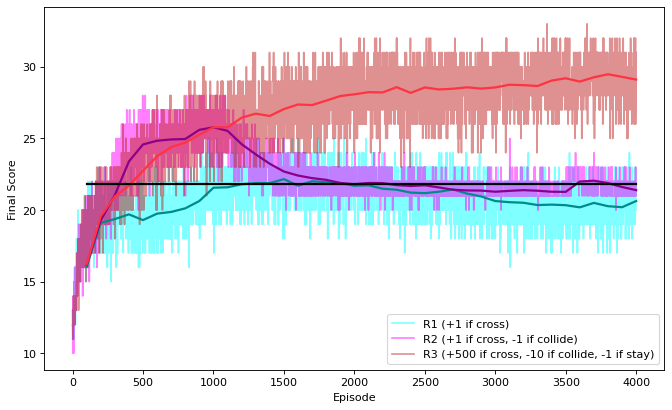

In [ ]:
baseline = [baseline_mean_score for i in range(4000)]

ax = aux_plots.plot_3scores(scores_2act_R1[:4000], scores_2act_R2[:4000], scores_2act_R3[:4000], "R1 (+1 if cross)", "R2 (+1 if cross, -1 if collide)", "R3 (+500 if cross, -10 if collide, -1 if stay)")

aux_plots.moving_average(scores_2act_R1[:4000], ax, label="R1 (+1 if cross)", color='darkcyan')
aux_plots.moving_average(scores_2act_R2[:4000], ax, label="R2 (+1 if cross, -1 if collide)", color='darkmagenta')
aux_plots.moving_average(scores_2act_R3[:4000], ax, label="R3 (+500 if cross, -10 if collide, -1 if stay)", color='#FF3341')
aux_plots.moving_average(baseline, ax, label='Baseline', color='black')

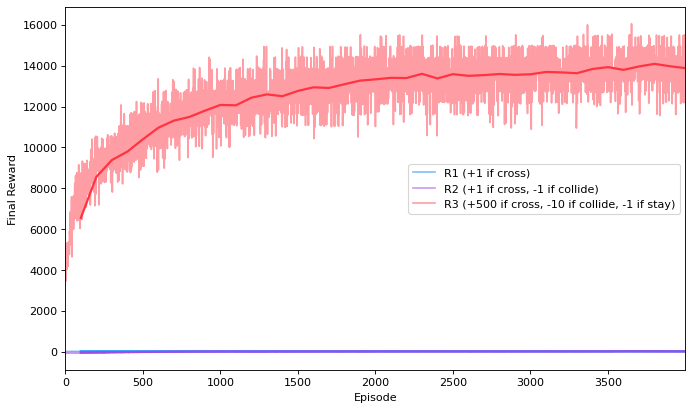

In [ ]:
ax = aux_plots.plot_3rewards(total_rewards_2act_R1[:4000], total_rewards_2act_R2[:4000], total_rewards_2act_R3[:4000], "R1 (+1 if cross)", "R2 (+1 if cross, -1 if collide)", "R3 (+500 if cross, -10 if collide, -1 if stay)")

aux_plots.moving_average(total_rewards_2act_R1[:4000], ax, label="R1 (+1 if cross)", color='#1F8FFF')
aux_plots.moving_average(total_rewards_2act_R2[:4000], ax, label="R2 (+1 if cross, -1 if collide)", color='#9C4BE7')
aux_plots.moving_average(total_rewards_2act_R3[:4000], ax, label="R3 (+500 if cross, -10 if collide, -1 if stay)", color='#FF3341')

Since the scales of the rewards vary a lot, we are separating R3 from R1 and R2, so we can compare than easily.

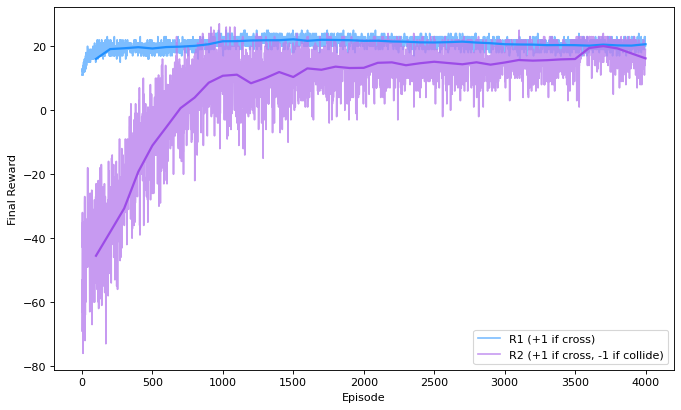

In [ ]:
ax = aux_plots.plot_2rewards(total_rewards_2act_R1[:4000], total_rewards_2act_R2[:4000], "R1 (+1 if cross)", "R2 (+1 if cross, -1 if collide)")

aux_plots.moving_average(total_rewards_2act_R1[:4000], ax, label="R1 (+1 if cross)", color='#1F8FFF')
aux_plots.moving_average(total_rewards_2act_R2[:4000], ax, label="R2 (+1 if cross, -1 if collide)", color='#9C4BE7')

Recall that R1 is the default reward policy of our system, where the chicken receives 1 reward each time it crosses the freeway, and thus it is the same as the score.

From these graphs we can see that for about 250 iterations the agents are scoring basically the same amount of points, but a few episodes latter, its behaviour change completely.
R2 starts to show a very good performance for a while, but as it explores more and tries to maximize its reward, it starts getting more "coward", avoiding colliding with cars at all costs, even if it means staying still.
The R2 agent prefers not to take risks, since one collision "takes" as much reward as it would get with a successful cross.
That is why after 1000 episodes its performance starts to degrade a lot.
This is the point where the agent starts to learn that in order to maximize its reward, it is better to stay still than to try to cross.
Thus, even though the reward obtained is still good, the score is not.

This behavior led us to the R3 approach, where we give a higher reward to crossing (500), while we still penalize collisions (-10) and also penalize staying still (-1).
By doing so, we incentivate the agent to cross while discouraging it to collide or staying still.
We give a higher penalty to collisions instead of staying still because the agent can avoid a collision by not moving.
After a thound episodes, we can already see that this is the solution that performs better among these three, **scoring close to 30 points** in 4000 episodes!

Notice that they haven't fully converged yet.
However, the gain that we obtain from now on is marginal, compared to the time it takes for it to run.

### Influence of the discount factor

The discount factor $\gamma$ determines how much the agent cares about rewards in the distant future relative to those in the immediate future.  

If $\gamma$=0, the agent will be completelly myopic and only learn about actions that produce an immediate reward.If $\gamma$=1, the agent will evaluate each of its actions based on the sum of total of all futures rewards.

We used a $\gamma$ value of 0.99 in order to make our agent care about distant future and we also decreased this value to 0.90 and 0.75 to see how they can impact the agent behavior. 

Thus, we will be experimenting with 3 different parameters set:

| Parameter | G1 | G2 | G3 |
|------|----|----|----|
| `GAMMA` | 0.99 | 0.90 | 0.75 |
| `AVAILABLE_ACTIONS` | 2 | 2 | 2 |
| `N0` | 2.5 | 2.5 | 2.5 |
| `CROSS` | 500 | 500 | 500 |
| `COLLISION` | -10 | -10 | -10 |
| `STILL` | -1 | -1 | -1 |

In [ ]:
scores_2act_gamma_0p99 = read_int_array_from_file('./QL/QL_scores_2act_R3.txt')
scores_2act_gamma_0p9 = read_int_array_from_file('./QL/QL_scores_2act_gamma_0p9.txt')
scores_2act_gamma_0p75 = read_int_array_from_file('./QL/QL_scores_2act_gamma_0p75.txt')

total_rewards_2act_gamma_0p99 = read_int_array_from_file('./QL/QL_total_rewards_2act_R3.txt')
total_rewards_2act_gamma_0p9 = read_int_array_from_file('./QL/QL_total_rewards_2act_gamma_0p9.txt')
total_rewards_2act_gamma_0p75 = read_int_array_from_file('./QL/QL_total_rewards_2act_gamma_0p75.txt')

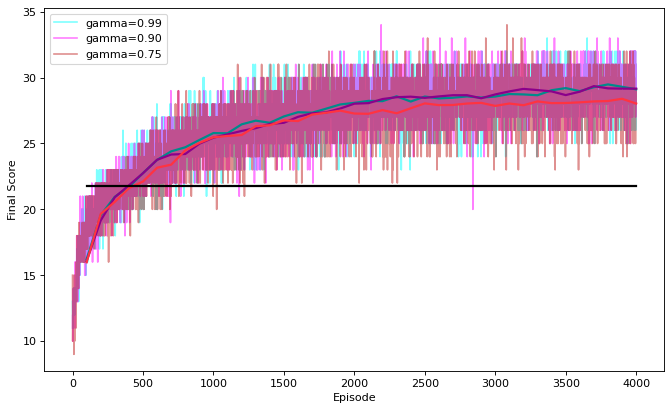

In [ ]:
baseline = [baseline_mean_score for i in range(4000)]

ax = aux_plots.plot_3scores(scores_2act_gamma_0p99[:4000], scores_2act_gamma_0p9[:4000], scores_2act_gamma_0p75[:4000], "gamma=0.99", "gamma=0.90", "gamma=0.75")

aux_plots.moving_average(scores_2act_gamma_0p99[:4000], ax, label="gamma=0.99", color='darkcyan')
aux_plots.moving_average(scores_2act_gamma_0p9[:4000], ax, label="gamma=0.90", color='darkmagenta')
aux_plots.moving_average(scores_2act_gamma_0p75[:4000], ax, label="gamma=0.75", color='#FF3341')
aux_plots.moving_average(baseline, ax, label='Baseline', color='black')

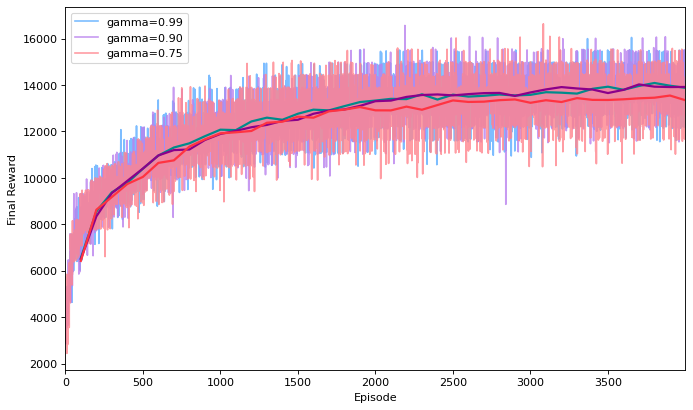

In [ ]:
ax = aux_plots.plot_3rewards(total_rewards_2act_gamma_0p99[:4000], total_rewards_2act_gamma_0p9[:4000], total_rewards_2act_gamma_0p75[:4000], "gamma=0.99", "gamma=0.90", "gamma=0.75")

aux_plots.moving_average(total_rewards_2act_gamma_0p99[:4000], ax, label="gamma=0.99", color='darkcyan')
aux_plots.moving_average(total_rewards_2act_gamma_0p9[:4000], ax, label="gamma=0.90", color='darkmagenta')
aux_plots.moving_average(total_rewards_2act_gamma_0p75[:4000], ax, label="gamma=0.75", color='#FF3341')

From the plots above we can see that $\gamma = 0.75$ led to poor results, but $\gamma = 0.9$ and $\gamma = 0.99$ seems to be equivalent.
An explanation is that when we make our agent short-sighted, it doesn't try to cross all the lanes and receive that huge reward we are offering as much as the far-sighted agents try.

That being said, we will be focusing on the $\gamma = 0.99$, arbitrarily.
We could be using the $0.9$ too, since it appears to have the same performance.

### Influence of the $N0$ parameter that is used to define the agent's exploration rate $\epsilon$

The exploration rate is the probability that our agent will explore the environment rather than exploit it.  
The $N0$ parameter is used to define the agent's exploration rate $\epsilon$ , where  $\epsilon = N0/(N0+N_{sa})$ and $N_{sa}$ is the number of times that state $s$ has been visited and taken the action $a$.

We used a very small value of $N0$ (0.001) so we can see how well the agent performs if this constant $N0$ had almost no impact in the exploration rate done and we also used $N0$ = 2.5 and $N0$ = 5.0 so we can see how the exploration rate impact the agent behavior.

All in all, these are the parameters that we are going to use to execute this experiment.

| Parameter | N1 | N2 | N3 |
|------|----|----|----|
| `GAMMA` | 0.99 | 0.99 | 0.99 |
| `AVAILABLE_ACTIONS` | 2 | 2 | 2 |
| `N0` | 0.001 | 2.5 | 5.0 |
| `CROSS` | 500 | 500 | 500 |
| `COLLISION` | -10 | -10 | -10 |
| `STILL` | -1 | -1 | -1 |

In [ ]:
scores_2act_N0_0 = read_int_array_from_file('./QL/QL_scores_2act_N0_0.txt')
scores_2act_N0_25 = read_int_array_from_file('./QL/QL_scores_2act_R3.txt')
scores_2act_N0_5 = read_int_array_from_file('./QL/QL_scores_2act_N0_5.txt')

total_rewards_2act_N0_0 = read_int_array_from_file('./QL/QL_total_rewards_2act_N0_0.txt')
total_rewards_2act_N0_25 = read_int_array_from_file('./QL/QL_total_rewards_2act_R3.txt')
total_rewards_2act_N0_5 = read_int_array_from_file('./QL/QL_total_rewards_2act_N0_5.txt')

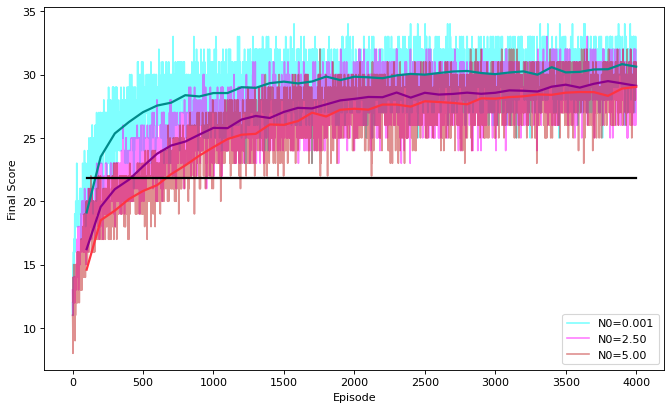

In [ ]:
baseline = [baseline_mean_score for i in range(4000)]

ax = aux_plots.plot_3scores(scores_2act_N0_0[:4000], scores_2act_N0_25[:4000], scores_2act_N0_5[:4000], "N0=0.001", "N0=2.50", "N0=5.00")

aux_plots.moving_average(scores_2act_N0_0[:4000], ax, label="N0=0.001", color='darkcyan')
aux_plots.moving_average(scores_2act_N0_25[:4000], ax, label="N0=2.50", color='darkmagenta')
aux_plots.moving_average(scores_2act_N0_5[:4000], ax, label="N0=5.00", color='#FF3341')
aux_plots.moving_average(baseline, ax, label='Baseline', color='black')

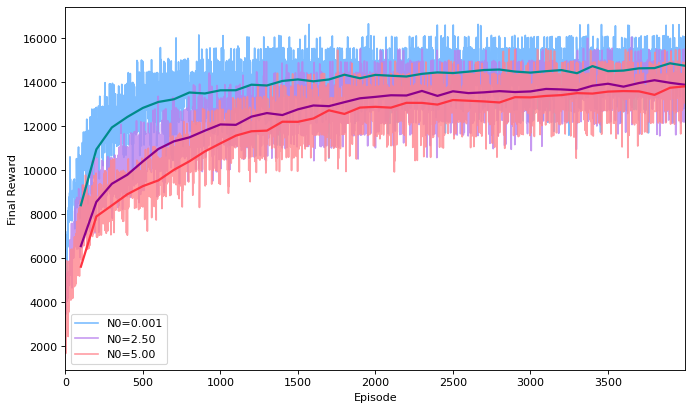

In [ ]:
ax = aux_plots.plot_3rewards(total_rewards_2act_N0_0[:4000], total_rewards_2act_N0_25[:4000], total_rewards_2act_N0_5[:4000], "N0=0.001", "N0=2.50", "N0=5.00")

aux_plots.moving_average(total_rewards_2act_N0_0[:4000], ax, label="N0=0.001", color='darkcyan')
aux_plots.moving_average(total_rewards_2act_N0_25[:4000], ax, label="N0=2.50", color='darkmagenta')
aux_plots.moving_average(total_rewards_2act_N0_5[:4000], ax, label="N0=5.00", color='#FF3341')

The exploration rate is the probability that our agent will explore the environment rather than exploit it.  

As we can see from the results show in the plots above, the lower is the $N0$ value, the better is the performance of the agent.
Although this migth seem counterintuitive at first, in fact, it stands to reason.
When we explore more (higher $N0$), we exploit less, leading to worst results in the beginning.
From the graphs above, we can see that all three lines are looking up, still increasing their values, and the gap between them is closing.
We expect to achive better results with higher $N0$s, but it would take too much time for it to happen (we even tested some of them overnight and it still wasn't enough).

Based on our reward function, it is fairly simple to detect which action should be taken in most of the states.
We want to move up always, unless it is leading to a collision.
Thus, frequently it is easy to detect the best action, and for most of the states we don't need to explore a lot to find it.

## Visualizations and conclusions

Bellow you can find some gifs showing how the agents behave.
You will find two different parameters, at different stages of training.
The bottom one is the agent that seems to perform the best.

We can see that the 4000-Champion **learned how to evade cars**, although still being really agressive in trying to cross the lanes! It is clear that the chicken goes as far as it can before hitting a car, and them suddenly stops until the car passes by, and starts running again (optimal behavior!).

On the other hand, we also discovered a *Coward* chicken.
Looking at the 4000-step Coward chicken, we can see that it became more afraid of hitting other cars because of the reward policy used (-1 per collision and +1 per successful crossing).
You can observe that sometimes it stops "far" from the cars, and only move after it has passed.

| #Episodes | 0 | 500 | 1000 | 2000 | 4000 |
|------|----|---|---|---|---|
| Coward - R2 N2.5 G0.99 | ![QL-R2_0](./gif/QL-R2_0.gif) | ![QL-R2_500](./gif/QL-R2_500.gif) | ![QL-R2_1000](./gif/QL-R2_1000.gif) | ![QL-R2_2000](./gif/QL-R2_2000.gif) | ![QL-R2_4000](./gif/QL-R2_4000.gif) |
| Champion - R3 N2.5 G0.99 | ![QL-R3_0](./gif/QL-R3_0.gif) | ![QL-R3_500](./gif/QL-R3_500.gif) | ![QL-R3_1000](./gif/QL-R3_1000.gif) | ![QL-R3_2000](./gif/QL-R3_2000.gif) | ![QL-R3_4000](./gif/QL-R3_4000.gif) |

---